In [86]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator
HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
x = QubitOperator('X0 Y1 Z2 Y3', 0.25j)
theta = np.pi
full_exp_circ_obj = full_exponentiated_PauliWord_circuit(x, theta)
UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
YY = QubitOperator('X0 X1 Y3', 0.25j)
pauliword_change_and_measure_obj = change_pauliword_to_Z_basis_then_measure(YY)
P_measure = cirq.Circuit(cirq.decompose_once((pauliword_change_and_measure_obj(*cirq.LineQubit.range(pauliword_change_and_measure_obj.num_qubits())))))

full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations(), *P_measure.all_operations()])
print(full_circuit)

0: ───X──────────H──────────@───────────────────────────────────────X───────────H───────────H───M───
                            │                                       │                           │
1: ───X──────────Rx(0.5π)───X───@───────────────────────X───────────@───────────Rx(-0.5π)───H───M───
                                │                       │                                       │
2: ─────────────────────────────X───@───────────────X───@───────────────────────────────────────┼───
                                    │               │                                           │
3: ───Rx(0.5π)──────────────────────X───Rz(-0.5π)───@───Rx(-0.5π)───Rx(-0.5π)───────────────────M───


## Get_Histogram_key

In [87]:
YY = QubitOperator('X0 X1 Y3', 0.25j)
Get_Histogram_key(YY)

'0,1,3'

## Simulate_Quantum_Circuit

In [105]:
num_shots = 1000
YY = QubitOperator('X0 X1 Y3', 0.25j)

histogram_string= Get_Histogram_key(YY)
Simulate_Quantum_Circuit(full_circuit, num_shots, histogram_string)

Counter({1: 118, 3: 123, 7: 129, 0: 130, 4: 121, 5: 114, 6: 147, 2: 118})

## Get_wavefunction

In [106]:
def Get_wavefunction(quantum_circuit, sig_figs=3):
    """
     Function to simulate quantum circuit and wavefunction

    """
    quantum_circuit_M_gates_removed = quantum_circuit.moments[
                                      :-1]  # removes last moment (aka measurement step - which collapses wavefunction)
    quantum_circuit_new = cirq.Circuit(quantum_circuit_M_gates_removed)
    simulator = cirq.Simulator()
    result = simulator.simulate(quantum_circuit_new, qubit_order=quantum_circuit_new.all_qubits())
    print(np.around(result.final_state, sig_figs))
    return result.final_state

In [107]:
YY = QubitOperator('X0 X1 Y3', 0.25j)

histogram_string= Get_Histogram_key(YY)
Get_wavefunction(full_circuit, sig_figs=3)

[-0.25+0.j    0.  +0.25j  0.  -0.25j  0.25+0.j   -0.25+0.j    0.  +0.25j
  0.  -0.25j  0.25+0.j    0.  +0.25j  0.25+0.j   -0.25+0.j    0.  -0.25j
  0.  -0.25j -0.25+0.j    0.25+0.j    0.  +0.25j]


array([-0.24999997+0.j        ,  0.        +0.24999997j,
        0.        -0.24999997j,  0.24999997+0.j        ,
       -0.24999997+0.j        ,  0.        +0.24999997j,
        0.        -0.24999997j,  0.24999997+0.j        ,
        0.        +0.24999997j,  0.24999997+0.j        ,
       -0.24999997+0.j        ,  0.        -0.24999997j,
        0.        -0.24999997j, -0.24999997+0.j        ,
        0.24999997+0.j        ,  0.        +0.24999997j], dtype=complex64)

## Return_as_binary

In [110]:
num_shots = 1000
YY = QubitOperator('X0 X1 Y3', 0.25j)

histogram_string= Get_Histogram_key(YY)
c_result = Simulate_Quantum_Circuit(full_circuit, num_shots, histogram_string)
Return_as_binary(c_result, histogram_string)

{'110': 131,
 '101': 128,
 '011': 129,
 '001': 128,
 '000': 116,
 '010': 130,
 '100': 116,
 '111': 122}

## expectation_value_by_parity

In [115]:
num_shots = 10000
YY = QubitOperator('X0 X1 Y3', 0.25j)

histogram_string= Get_Histogram_key(YY)
c_result = Simulate_Quantum_Circuit(full_circuit, num_shots, histogram_string)
b_result = Return_as_binary(c_result, histogram_string)

expectation_value_by_parity(b_result)

-0.0023

In [ ]:
def expectation_value_by_parity(binary_counter_result):
    """

    < Z >  = (num_0 - num_1) / total_num_measurements = (num_0 - num_1) / (num_0 + num_1)

    note that for multiple qubits one multiplies <Z> on each line. Therefore can calculate value from parity
    of output bit string

    :param binary_counter_result:
    :type binary_counter_result: dict
    e.g.
        {
            1: {'11': 10000},
            2: {'10': 9998, '01': 2},
            3: {'10': 10000},
            4: {'10': 10000},
            5: {'10': 10000},
            6: {'00': 9995, '01': 4, '10': 1},
            7: {'1': 9334, '0': 666},
            8: {'1': 9351, '0': 649},
            9: {'0': 9606, '1': 394},
            10: {'0': 9594, '1': 406}
        }

    :return: expectation value <Z>
    :rtype: float
    """
    Total = 0
    total_no_measurements = 0
    for state in binary_counter_result:
        parity = calc_parity(state)
        if parity == 0:
            Total += binary_counter_result[state]
            total_no_measurements += binary_counter_result[state]
        elif parity == 1:
            Total -= binary_counter_result[state]
            total_no_measurements += binary_counter_result[state]
        else:
            raise ValueError('state {} not allowed'.format(state))
    #print(binary_counter_result, total_no_measurements, Total)
    expectation_value = Total / total_no_measurements
    return expectation_value

In [121]:
expectation_value_by_parity({'110': 10,
                            '111': 90,
                            '0': 90})


0.05263157894736842

In [120]:
(10-180)/190

-0.8947368421052632

In [8]:
from quchem.Hamiltonian_Generator_Functions import *
### Parameters
Molecule = 'H2'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-3g'

### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!

Hamilt.Get_Molecular_Hamiltonian(Get_H_matrix=False)
QubitHam = Hamilt.Get_Qubit_Hamiltonian(transformation='JW')

ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)

Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,
                                                                                                                    transformation='JW')

full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

In [9]:
n_shots= 1000

VQE_exp = VQE_Experiment(QubitHam, ansatz_cirq_circuit, n_shots)
VQE_exp.Calc_Energy()

-0.06689197512157967

In [ ]:
n_shots=1000

def GIVE_ENERGY(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(theta_parameters_ia)]
    theta_ijab = theta_ia_theta_jab_list[len(theta_parameters_ia):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

    VQE_exp = VQE_Experiment(QubitHam, ansatz_cirq_circuit, n_shots)
    

    return VQE_exp.Calc_Energy()

from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[3,2,3]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

In [34]:
Qubit_Op_list_Second_Quant_CC_Ops_ia

[-0.5j [X0 Z1 Y2] +
 0.5j [Y0 Z1 X2],
 -0.5j [X1 Z2 Y3] +
 0.5j [Y1 Z2 X3]]

In [10]:
# from quchem.quantum_circuit_functions import Generate_Full_Q_Circuit


# class VQE_Experiment():
#     def __init__(self, qubitHamiltonian, ansatz_circuit, n_shots):
#         self.qubitHamiltonian = qubitHamiltonian
#         self.ansatz_circuit = ansatz_circuit
#         self.n_shots = n_shots

#     def Calc_Energy(self):
#         t_results=[]
#         E_list=[]
#         for qubitOp in self.qubitHamiltonian:
#             for PauliWord, const in qubitOp.terms.items():
#                 if PauliWord is not ():
                    
#                     Q_circuit = Generate_Full_Q_Circuit(self.ansatz_circuit, qubitOp)
#                     hist_key_str = Get_Histogram_key(qubitOp)
#                     int_state_counter = Simulate_Quantum_Circuit(Q_circuit, self.n_shots, hist_key_str)
#                     binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
#                     exp_result = expectation_value_by_parity(binary_state_counter)
#                     E_list.append(exp_result*const)
                    
#                     t_results.append((exp_result, const))
#                 else:
#                     E_list.append(const)
#                     t_results.append((1, const))
                    
                    
#         return sum(E_list).real, t_results

#     def Get_wavefunction_of_state(self, sig_figs=3):
#         return Get_wavefunction(self.ansatz_circuit, sig_figs=sig_figs)


In [146]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', 0.25j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
H2_ansatz(np.pi)               

0: ───X───Rx(0.5π)───@───────────────────────────────X───Rx(-0.5π)───
                     │                               │
1: ───X───H──────────X───@───────────────────────X───@───H───────────
                         │                       │
2: ───H──────────────────X───@───────────────X───@───H───────────────
                             │               │
3: ───H──────────────────────X───Rz(-0.5π)───@───H───────────────────

0: Input_to_Funct: [2.1]: Output: -0.08443212406548904
1: Input_to_Funct: [2.1]: Output: -0.06894576600712284
2: Input_to_Funct: [2.1]: Output: -0.05645621710188135
3: Input_to_Funct: [2.1]: Output: -0.07234518868906484
4: Input_to_Funct: [2.10625]: Output: -0.050239834759196515
5: Input_to_Funct: [2.10625]: Output: -0.0626222898421704
6: Input_to_Funct: [2.10625]: Output: -0.07910659741417245
7: Input_to_Funct: [2.10625]: Output: -0.07821044477738552
8: Input_to_Funct: [2.10625]: Output: -0.07782123027279887
9: Input_to_Funct: [2.10625]: Output: -0.08599602064416463
10: Input_to_Funct: [2.10615234]: Output: -0.08339626950865478
11: Input_to_Funct: [2.10615234]: Output: -0.09795216585004893
12: Input_to_Funct: [2.10615234]: Output: -0.04731392732456891
13: Input_to_Funct: [2.10615234]: Output: -0.09480376716404962
14: Input_to_Funct: [2.10615845]: Output: -0.04927654026011423
15: Input_to_Funct: [2.10615845]: Output: -0.08501857359207324
16: Input_to_Funct: [2.10615845]: Output: -0.080

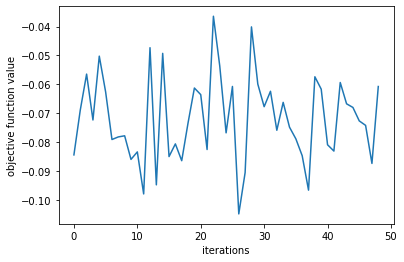

In [147]:
n_shots=1000

def GIVE_ENERGY(THETA):
   
    ansatz_cirq_circuit = H2_ansatz(THETA)

    VQE_exp = VQE_Experiment(QubitHam, ansatz_cirq_circuit, n_shots)

    return VQE_exp.Calc_Energy()

from quchem.Scipy_Optimizer import *
THETA_params=[2]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

In [180]:
class VQE_Experiment():
    def __init__(self, qubitHamiltonian, ansatz_circuit, n_shots):
        self.qubitHamiltonian = qubitHamiltonian
        self.ansatz_circuit = ansatz_circuit
        self.n_shots = n_shots

    def Calc_Energy(self):

        E_list=[]
        for qubitOp in self.qubitHamiltonian:
            for PauliWord, const in qubitOp.terms.items():
                if PauliWord is not ():
                    Q_circuit = Generate_Full_Q_Circuit(self.ansatz_circuit, qubitOp)
                    
                    print(Q_circuit)
                    print(qubitOp)
                    print('')
                    
                    hist_key_str = Get_Histogram_key(qubitOp)
                    int_state_counter = Simulate_Quantum_Circuit(Q_circuit, self.n_shots, hist_key_str)
                    binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
                    exp_result = expectation_value_by_parity(binary_state_counter)
                    print(exp_result)
                    E_list.append(exp_result*const)
                    
                    print(binary_state_counter)
                    
                    print('')
                    print('')
                    print('###')
                else:
                    E_list.append(const)
        print(E_list)
        return sum(E_list).real

    def Get_wavefunction_of_state(self, sig_figs=3):
        return Get_wavefunction(self.ansatz_circuit, sig_figs=sig_figs)


In [181]:
ansatz = H2_ansatz(2*np.pi) 
xx = VQE_Experiment(QubitHam, ansatz, 10000)
xx.Calc_Energy()

0: ───X───Rx(0.5π)───@────────────────────────────X───Rx(-0.5π)───M───
                     │                            │
1: ───X───H──────────X───@────────────────────X───@───H───────────────
                         │                    │
2: ───H──────────────────X───@────────────X───@───H───────────────────
                             │            │
3: ───H──────────────────────X───Rz(-π)───@───H───────────────────────
(0.17141282639402405+0j) [Z0]

-0.0054
{'0': 4973, '1': 5027}


###
0: ───X───Rx(0.5π)───@────────────────────────────X───Rx(-0.5π)───────
                     │                            │
1: ───X───H──────────X───@────────────────────X───@───H───────────M───
                         │                    │
2: ───H──────────────────X───@────────────X───@───H───────────────────
                             │            │
3: ───H──────────────────────X───Rz(-π)───@───H───────────────────────
(0.171412826394024+0j) [Z1]

-0.0204
{'1': 5102, '0': 4898}


###
0: ───X───

0.5203166400594361

In [ ]:
#TODO
# write maths of PauliMeasurement!
# something is off!!!

$$ U_{UCCSD}|HF\rangle = |\psi_{UCCSD}\rangle$$ 

$$ \langle \psi_{UCCSD}| H |\psi_{UCCSD}\rangle$$ 

$$P|\psi_{UCCSD}\rangle$$ 

$$X|\pm\rangle = ZH|\pm\rangle = Z|0/1\rangle$$ 

$$Y|i\pm \rangle = ZR_{x}\big(\frac{\pi}{2} \big)|i\pm\rangle = Z|0/1\rangle$$ 

In [152]:
circuit = cirq.Circuit(cirq.H(cirq.LineQubit(1)),cirq.X(cirq.LineQubit(1)), cirq.measure(cirq.LineQubit(1)))

simulator = cirq.Simulator()
raw_result = simulator.run(circuit, repetitions=100)
hist_result = raw_result.histogram(key='1')
hist_result

Counter({0: 47, 1: 53})

In [166]:
circuit = cirq.Circuit(cirq.H(cirq.LineQubit(1)),
                       cirq.CNOT(cirq.LineQubit(1),cirq.LineQubit(2)),
                       cirq.measure(cirq.LineQubit(1),cirq.LineQubit(2)))
simulator = cirq.Simulator()
raw_result = simulator.run(circuit, repetitions=100)
hist_result = raw_result.histogram(key='1,2')
print(hist_result)

bin_dict = Return_as_binary(hist_result, '1,2')

print(bin_dict)

print(expectation_value_by_parity(bin_dict))

Get_wavefunction(circuit, sig_figs=3)

Counter({0: 51, 3: 49})
{'00': 51, '11': 49}
1.0
[ 0.707+0.j -0.   +0.j  0.   +0.j  0.707+0.j]


array([ 0.70710677+0.j, -0.        +0.j,  0.        +0.j,  0.70710677+0.j],
      dtype=complex64)

In [170]:
circuit = cirq.Circuit(cirq.H(cirq.LineQubit(1)),
                       cirq.X(cirq.LineQubit(1)),
                       cirq.measure(cirq.LineQubit(1),cirq.LineQubit(2)))
simulator = cirq.Simulator()
raw_result = simulator.run(circuit, repetitions=1000)
hist_result = raw_result.histogram(key='1,2')
print(hist_result)

bin_dict = Return_as_binary(hist_result, '1,2')

print(bin_dict)

print(expectation_value_by_parity(bin_dict))

Get_wavefunction(circuit, sig_figs=3)

Counter({2: 526, 0: 474})
{'00': 474, '10': 526}
-0.052
[0.707+0.j 0.707+0.j]


array([0.70710677+0.j, 0.70710677+0.j], dtype=complex64)

In [172]:
((526+474*2)-526)/((526+474*2)+526)

0.474

In [173]:
(474-526)/(474+526)

-0.052